#### Data Comparison

Examining shipdock environmental data alongside order fulfillment data to study any correlations.

In [1]:
from dotenv import load_dotenv
import os
from supabase import create_client
import pandas as pd
import seaborn as sns

#### Create Supabase client

In [2]:
load_dotenv()
url = os.getenv('DB_URL')
key = os.getenv('DB_API_KEY')
supabase = create_client(url, key)

#### Retrieve table data

The two tables in the database have a differing number of rows, since multiple orders can occur within a given hourly timestamp from the environmental data. Instead of bringing data in and merging with a complex SQL query, I'm using pd.merge_asof.

1. Timestamps come in as string objects, so convert to timestamp dtype
2. With pd.merge_asof, the left_on and right_on fields must be sorted and contain datetime, integer or float values, so bring the left and right dataframes in sorted.

In [3]:
def supabase_retrieve(table):
    try: 
        response = (
            supabase.from_(table)   # 'from' is a reserved word in Python
            .select("*")
            .execute()
        )

    except Exception as e:
        print(f"An error occurred: {e}")

    return response.data

fulfillment_data_df = pd.DataFrame(supabase_retrieve("order_fulfillment_data"))
fulfillment_data_df[['timestamp', 'ship_date', 'pack_date']] = fulfillment_data_df[['timestamp', 'ship_date', 'pack_date']].apply(pd.to_datetime)
sensor_data_df = pd.DataFrame(supabase_retrieve("shipdock_environmental_data"))
sensor_data_df['timestamp'] = pd.to_datetime(sensor_data_df['timestamp'] )

# fulfillment_data_df.info()
# sensor_data_df.info()

merged_df = pd.merge_asof(
    fulfillment_data_df.sort_values('pack_date'),
    sensor_data_df.sort_values('timestamp'),
    left_on='pack_date',                              # left_on and right_on must be datetime, integer or float and ordered
    right_on='timestamp',
    direction='nearest'                               # 'nearest' to search for closest matches, vs prior or subsequent
)

# Correlations occur on numeric type fields, so I need a boolean version of defect_reported
merged_df.insert(4, 'defect_reported_bool', merged_df['defect_reported'].notnull(), allow_duplicates=False)

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4374 entries, 0 to 4373
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id_x                  4374 non-null   int64         
 1   timestamp_x           4374 non-null   datetime64[ns]
 2   ship_date             4374 non-null   datetime64[ns]
 3   defect_reported       274 non-null    object        
 4   defect_reported_bool  4374 non-null   bool          
 5   pack_date             4374 non-null   datetime64[ns]
 6   order_id              4374 non-null   object        
 7   number_of_items       4374 non-null   int64         
 8   ship_method           4374 non-null   object        
 9   box_size              4374 non-null   object        
 10  id_y                  4374 non-null   int64         
 11  timestamp_y           4374 non-null   datetime64[ns]
 12  temperature           4374 non-null   float64       
 13  noise_level       

#### TEST: Basic subset operations

In [4]:
merged_df[merged_df['defect_reported'].notnull()].head(5)

,id_x,timestamp_x,ship_date,defect_reported,defect_reported_bool,pack_date,order_id,number_of_items,ship_method,box_size,id_y,timestamp_y,temperature,noise_level
10,1658,2024-05-31 19:00:00,2024-06-01 17:00:00,poorly packed,True,2024-06-01 09:00:00,0b99d8cf-6654-4a9a-88b6-aeb9807e3e8f,2,fedex,B,622,2024-06-01 09:00:00,60.45,74.80
30,1677,2024-06-01 13:00:00,2024-06-02 03:00:00,missing items,True,2024-06-01 15:00:00,d2843110-addf-4344-84c6-07995ef57c62,3,dhl,A,628,2024-06-01 15:00:00,67.47,79.43
32,1681,2024-05-31 16:00:00,2024-06-02 00:00:00,wrong items,True,2024-06-01 15:00:00,a4d55f5f-e24c-45c5-9989-d3661435a948,5,fedex,A,628,2024-06-01 15:00:00,67.47,79.43
33,1680,2024-06-01 06:00:00,2024-06-02 04:00:00,wrong items,True,2024-06-01 15:00:00,284f07db-f568-4f61-9c71-513512208e7e,1,usps,A,628,2024-06-01 15:00:00,67.47,79.43
39,1687,2024-06-02 04:00:00,2024-06-03 04:00:00,poorly packed,True,2024-06-02 09:00:00,93a53eb5-4678-4f15-948d-dd52759580d3,2,fedex,C,632,2024-06-02 09:00:00,60.75,64.19


In [5]:
merged_df[merged_df['ship_method'].str.contains('fedex', regex=False)].head(5)

,id_x,timestamp_x,ship_date,defect_reported,defect_reported_bool,pack_date,order_id,number_of_items,ship_method,box_size,id_y,timestamp_y,temperature,noise_level
3,1652,2024-06-01 04:00:00,2024-06-02 07:00:00,None,False,2024-06-01 08:00:00,cb5fc7f8-9aa0-46ba-a2f1-dee6f13655e6,3,fedex,C,621,2024-06-01 08:00:00,60.18,36.65
8,1656,2024-05-31 23:00:00,2024-06-02 05:00:00,None,False,2024-06-01 09:00:00,892443f5-bbc8-4b64-8b80-9c260720a782,3,fedex,A,622,2024-06-01 09:00:00,60.45,74.80
9,1657,2024-06-01 00:00:00,2024-06-02 03:00:00,None,False,2024-06-01 09:00:00,e7974d91-d59a-495d-9611-21452f818b75,1,fedex,C,622,2024-06-01 09:00:00,60.45,74.80
10,1658,2024-05-31 19:00:00,2024-06-01 17:00:00,poorly packed,True,2024-06-01 09:00:00,0b99d8cf-6654-4a9a-88b6-aeb9807e3e8f,2,fedex,B,622,2024-06-01 09:00:00,60.45,74.80
13,1661,2024-06-01 02:00:00,2024-06-01 20:00:00,None,False,2024-06-01 10:00:00,1dc97d39-e406-4ec9-b492-498f71d43c9b,5,fedex,A,623,2024-06-01 10:00:00,60.47,36.15


In [6]:
merged_df[merged_df['noise_level'] > 70].head(5)

,id_x,timestamp_x,ship_date,defect_reported,defect_reported_bool,pack_date,order_id,number_of_items,ship_method,box_size,id_y,timestamp_y,temperature,noise_level
7,1655,2024-06-01 01:00:00,2024-06-01 19:00:00,None,False,2024-06-01 09:00:00,990623e3-19b5-4080-b1b8-3165db8dc424,3,ups,B,622,2024-06-01 09:00:00,60.45,74.80
8,1656,2024-05-31 23:00:00,2024-06-02 05:00:00,None,False,2024-06-01 09:00:00,892443f5-bbc8-4b64-8b80-9c260720a782,3,fedex,A,622,2024-06-01 09:00:00,60.45,74.80
9,1657,2024-06-01 00:00:00,2024-06-02 03:00:00,None,False,2024-06-01 09:00:00,e7974d91-d59a-495d-9611-21452f818b75,1,fedex,C,622,2024-06-01 09:00:00,60.45,74.80
10,1658,2024-05-31 19:00:00,2024-06-01 17:00:00,poorly packed,True,2024-06-01 09:00:00,0b99d8cf-6654-4a9a-88b6-aeb9807e3e8f,2,fedex,B,622,2024-06-01 09:00:00,60.45,74.80
14,1662,2024-06-01 11:00:00,2024-06-02 05:00:00,None,False,2024-06-01 12:00:00,a66fd1af-04b0-435d-8367-4cabf7d3f302,2,fedex,B,625,2024-06-01 12:00:00,64.67,74.58


#### Correlation analysis

The original hypothesis says that bringing down air temperature and noise levels would reduce error rates. So I want to look at correlation analysis in two time periods: 'pre' and 'post' applying temperature and noise mitigation.

In [7]:
merged_df['mitigation_period'] = merged_df['pack_date'].dt.month.map(
    lambda m: 'pre' if m in [6, 7] else 'post'
)

merged_df.head()

,id_x,timestamp_x,ship_date,defect_reported,defect_reported_bool,pack_date,order_id,number_of_items,ship_method,box_size,id_y,timestamp_y,temperature,noise_level,mitigation_period
0,1654,2024-05-31 16:00:00,2024-06-01 23:00:00,None,False,2024-06-01 08:00:00,0cba0463-629f-4486-ae60-996ab3c9dc10,5,ups,B,621,2024-06-01 08:00:00,60.18,36.65,pre
1,1650,2024-06-01 04:00:00,2024-06-01 18:00:00,None,False,2024-06-01 08:00:00,f563aa2e-221d-43b9-bd71-27e239aabc77,3,usps,A,621,2024-06-01 08:00:00,60.18,36.65,pre
2,1651,2024-05-31 22:00:00,2024-06-02 07:00:00,None,False,2024-06-01 08:00:00,03bf4431-a702-413e-8102-d8d2769bad13,3,dhl,C,621,2024-06-01 08:00:00,60.18,36.65,pre
3,1652,2024-06-01 04:00:00,2024-06-02 07:00:00,None,False,2024-06-01 08:00:00,cb5fc7f8-9aa0-46ba-a2f1-dee6f13655e6,3,fedex,C,621,2024-06-01 08:00:00,60.18,36.65,pre
4,1653,2024-05-31 18:00:00,2024-06-02 06:00:00,None,False,2024-06-01 08:00:00,fc7e09fb-cb80-45f8-b241-3213e666373d,3,ups,A,621,2024-06-01 08:00:00,60.18,36.65,pre


In [8]:
merged_df.corr(numeric_only=True).round(2) 
# 0.15 between defect_reported and temperature and 0.15 between defect_reported and noise_level

,id_x,defect_reported_bool,number_of_items,id_y,temperature,noise_level
id_x,1.00,-0.10,-0.01,1.00,-0.04,-0.12
defect_reported_bool,-0.10,1.00,-0.01,-0.10,0.16,0.15
number_of_items,-0.01,-0.01,1.00,-0.01,-0.02,0.04
id_y,1.00,-0.10,-0.01,1.00,-0.04,-0.12
temperature,-0.04,0.16,-0.02,-0.04,1.00,0.01
noise_level,-0.12,0.15,0.04,-0.12,0.01,1.00


#### Test: Groupby operation

groupby() returns a Group By object, a blueprint for performing operations within each group. Performing an aggregation or transformation action converts it back into a Dataframe.

In [ ]:
grouped_data = merged_df.groupby(['mitigation_period', 'defect_reported_bool'], as_index=False, observed=False)

agg_df = grouped_data[['temperature','noise_level']].agg(['mean', 'median', 'std']).round(2)
agg_df.columns = ['Mitigation Period', 'Defect Reported (Bool)', 'Temperature - Mean', 'Temperature - Median', 'Temperature - Std', 'Noise Level - Mean', 'Noise Level - Median', 'Noise Level - Std']
agg_df.head()

,Mitigation Period,Defect Reported (Bool),Temperature - Mean,Temperature - Median,Temperature - Std,Noise Level - Mean,Noise Level - Median,Noise Level - Std
0,post,False,69.12,68.97,6.65,41.99,40.27,13.48
1,post,True,67.12,66.40,6.06,43.88,42.40,12.35
2,pre,False,70.00,69.34,8.01,45.49,40.94,18.18
3,pre,True,76.49,80.91,10.21,56.11,64.22,18.70


#### Analysis for visualization

Defect rate per temperature range

In [ ]:
# merged_df['temp_range'].describe()

# Create a temp_range
merged_df['temp_range'] = pd.cut(
    merged_df['temperature'],
    bins=[60, 65, 70, 75, 80, 85, 90],
    labels=['60-65', '65-70', '70-75', '75-80', '80-85', '85-90']
)

# Create grouping by mitigation_period and temp_range, aggregate total_orders and defect_count 
grouped_temp = (
    merged_df.groupby(['mitigation_period', 'temp_range'], observed=False).agg(
        total_orders=('order_id', 'count'),
        defect_count=('defect_reported', lambda x: x.notna().sum())
    )
).sort_values(by='mitigation_period', ascending=False)

# On the returned dataframe, calculate defect_rate from total_orders and defect_count
grouped_temp['defect_rate'] = grouped_temp['defect_count'] / grouped_temp['total_orders']

print(grouped_temp)

                              total_orders  defect_count  defect_rate
mitigation_period temp_range                                         
pre               60-65                730          53.0     0.072603
                  65-70                395          17.0     0.043038
                  70-75                447          17.0     0.038031
                  75-80                265          14.0     0.052830
                  80-85                222          67.0     0.301802
                  85-90                150          52.0     0.346667
post              60-65                725          23.0     0.031724
                  65-70                486          15.0     0.030864
                  70-75                428           9.0     0.021028
                  75-80                526           7.0     0.013308
                  80-85                  0           NaN          NaN
                  85-90                  0           NaN          NaN


C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\269539083.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  merged_df.groupby(['mitigation_period', 'temp_range']).agg(


Defect rate per noise level range

In [ ]:
# merged_df['noise_level'].describe()

# Create a noise_range
merged_df['noise_level_range'] = pd.cut(
    merged_df['noise_level'],
    bins = [20, 30, 40, 50, 60, 70, 80],
    labels = ['20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
)

# Create grouping by mitigation_period and noise_range, aggregate total_orders and defect_count
grouped_noise = merged_df.groupby(['mitigation_period', 'noise_level_range'], observed=False).agg(
    total_orders = ('order_id', 'count'),
    defect_count = ('defect_reported', lambda x: x.notna().sum())
).sort_values(by='mitigation_period', ascending=False)

# On the returned dataframe, calculate defect_rate from total_orders and defect_count
grouped_noise['defect_rate'] = grouped_noise['defect_count'] / grouped_noise['total_orders']

print(grouped_noise)

                                     total_orders  defect_count  defect_rate
mitigation_period noise_level_range                                         
pre               20-30                       487          28.0     0.057495
                  30-40                       537          36.0     0.067039
                  40-50                       449          22.0     0.048998
                  50-60                         0           NaN          NaN
                  60-70                       380          72.0     0.189474
                  70-80                       356          62.0     0.174157
post              20-30                       513          10.0     0.019493
                  30-40                       551          15.0     0.027223
                  40-50                       424          12.0     0.028302
                  50-60                       677          17.0     0.025111
                  60-70                         0           NaN          NaN

C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\1141754201.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_noise = merged_df.groupby(['mitigation_period', 'noise_level_range']).agg(


Defect rate overall

In [ ]:
grouped_all_defects = merged_df.groupby('mitigation_period', observed=False).agg(
    total_orders = ('order_id', 'count'),
    defect_count = ('defect_reported', lambda x: x.notna().sum())
).sort_values(by='mitigation_period', ascending=False)

grouped_all_defects['defect_rate'] = grouped_all_defects['defect_count'] / grouped_all_defects['total_orders'] 

# Set a new column to use in bar plot to force ordering 'pre' before 'post'
grouped_all_defects['period_label'] = grouped_all_defects.index.str.capitalize() + '-mitigation'

print(grouped_all_defects)

                   total_orders  defect_count  defect_rate     period_label
mitigation_period                                                          
pre                        2209           220     0.099593   Pre-mitigation
post                       2165            54     0.024942  Post-mitigation


Pivot tables to cross-reference defects

In [ ]:
# Create 'pre' and 'post' dataframes as two pivot tables

pivot_periods = ['pre', 'post']
pivot_objects = {}

for period in pivot_periods:
    pivot_objects[period] = merged_df[merged_df['mitigation_period'] == period]
    pivot_objects[f'{period}_pivot'] = pivot_objects[period].pivot_table(
        index='temp_range',
        columns='noise_level_range',
        values='defect_reported',
        aggfunc=lambda x: x.notna().mean()
    )

# pivot_objects['pre_pivot']
# pivot_objects['post_pivot]

C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\3693067114.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_objects[f'{period}_pivot'] = pivot_objects[period].pivot_table(
C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\3693067114.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_objects[f'{period}_pivot'] = pivot_objects[period].pivot_table(


#### Visualizations

Temperature range bar plot

C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\3125190866.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  temp_plot.set_yticklabels(['{:,.0%}'.format(x) for x in temp_plot.get_yticks()])


[Text(0, 0.0, '0%'),
 Text(0, 0.05, '5%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.15000000000000002, '15%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.25, '25%'),
 Text(0, 0.30000000000000004, '30%'),
 Text(0, 0.35000000000000003, '35%'),
 Text(0, 0.4, '40%')]

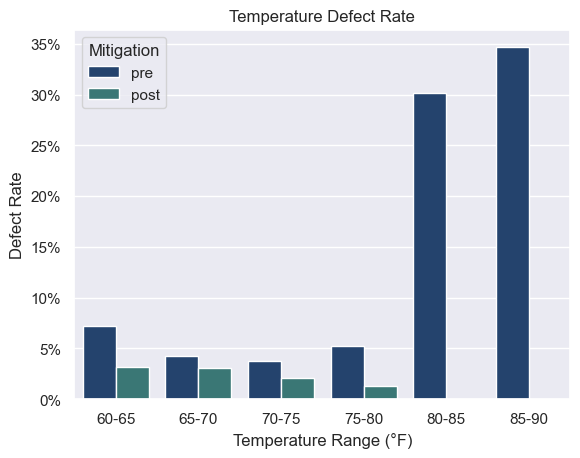

In [ ]:
sns.set_theme(style='darkgrid', palette='gist_earth')

temp_plot = sns.barplot(
    data=grouped_temp.reset_index(),        # get rid of the multindex from the grouping
    x='temp_range',
    y='defect_rate',
    hue='mitigation_period'
)

temp_plot.set(xlabel='Temperature Range (°F)', ylabel='Defect Rate')
temp_plot.legend(title='Mitigation')
temp_plot.set_title("Temperature Defect Rate")
temp_plot.set_yticklabels(['{:,.0%}'.format(x) for x in temp_plot.get_yticks()])

Noise level bar plot

C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\716555677.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  noise_plot.set_yticklabels(['{:,.0%}'.format(x) for x in noise_plot.get_yticks()])


[Text(0, 0.0, '0%'),
 Text(0, 0.025, '2%'),
 Text(0, 0.05, '5%'),
 Text(0, 0.07500000000000001, '8%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.125, '12%'),
 Text(0, 0.15000000000000002, '15%'),
 Text(0, 0.17500000000000002, '18%'),
 Text(0, 0.2, '20%')]

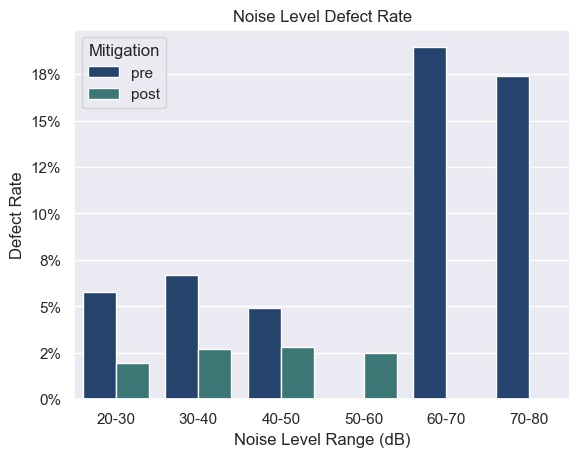

In [ ]:
sns.set_theme(style='darkgrid', palette='gist_earth')

print(grouped_noise)

noise_plot = sns.barplot(
    data=grouped_noise.reset_index(),        # get rid of the multindex from the grouping
    x='noise_level_range',
    y='defect_rate',
    hue='mitigation_period'
)

noise_plot.set(xlabel='Noise Level Range (dB)', ylabel='Defect Rate')
noise_plot.legend(title='Mitigation')
noise_plot.set_title("Noise Level Defect Rate")
noise_plot.set_yticklabels(['{:,.0%}'.format(x) for x in noise_plot.get_yticks()])

All defects bar plot

C:\Users\cylinder\AppData\Local\Temp\ipykernel_27252\1765646041.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  all_defects_plot.set_yticklabels(['{:,.0%}'.format(x) for x in all_defects_plot.get_yticks()])


[Text(0, 0.0, '0%'),
 Text(0, 0.02, '2%'),
 Text(0, 0.04, '4%'),
 Text(0, 0.06, '6%'),
 Text(0, 0.08, '8%'),
 Text(0, 0.1, '10%'),
 Text(0, 0.12, '12%')]

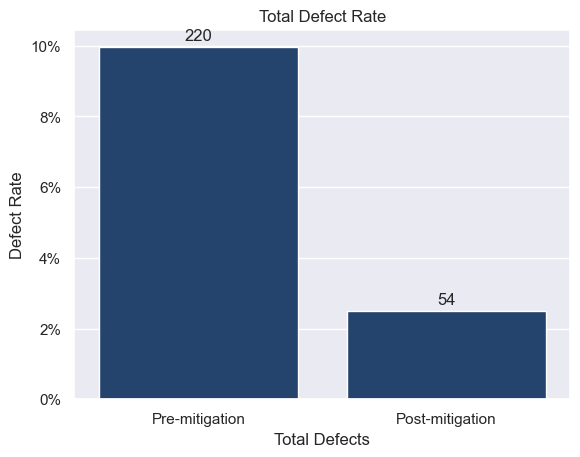

In [174]:
sns.set_theme(style='darkgrid', palette='gist_earth')

all_defects_plot = sns.barplot(
    data=grouped_all_defects.reset_index(),        # get rid of the multindex from the grouping
    x='period_label',
    y='defect_rate'
)

for i, val in enumerate(grouped_all_defects['defect_count']):
    all_defects_plot.text(i, grouped_all_defects['defect_rate'].iloc[i] + 0.002, f"{val}", ha='center')

all_defects_plot.set(xlabel='Total Defects', ylabel='Defect Rate')
all_defects_plot.set_title("Total Defect Rate")
all_defects_plot.set_yticklabels(['{:,.0%}'.format(x) for x in all_defects_plot.get_yticks()])

Heatmaps

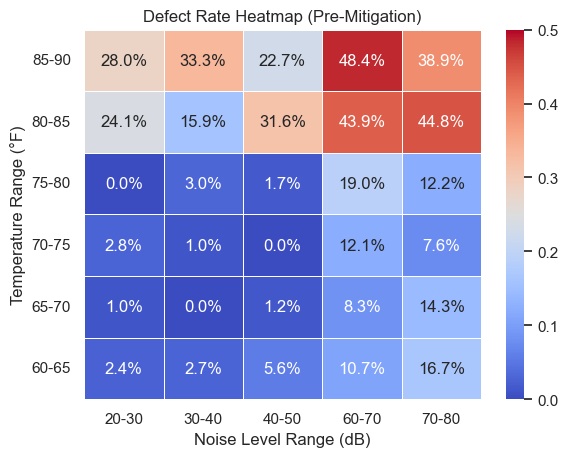

In [73]:
pre_defect_heatmap = sns.heatmap(pivot_objects['pre_pivot'], annot=True, cmap='coolwarm', vmin=0, vmax=0.5, 
                                  linewidths=0.5, fmt='.1%')

pre_defect_heatmap.set(xlabel='Noise Level Range (dB)', ylabel='Temperature Range (°F)')
pre_defect_heatmap.invert_yaxis()
pre_defect_heatmap.set_title("Defect Rate Heatmap (Pre-Mitigation)")
pre_defect_heatmap.tick_params(axis='y', labelrotation=0)

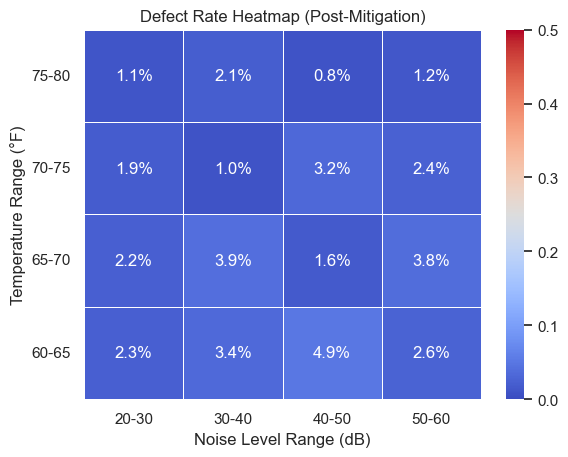

In [51]:
post_defect_heatmap = sns.heatmap(pivot_objects['post_pivot'], annot=True, cmap='coolwarm', vmin=0, vmax=0.5, 
                                  linewidths=0.5, fmt='.1%')

post_defect_heatmap.set(xlabel='Noise Level Range (dB)', ylabel='Temperature Range (°F)')
post_defect_heatmap.invert_yaxis()
post_defect_heatmap.set_title("Defect Rate Heatmap (Post-Mitigation)")
post_defect_heatmap.tick_params(axis='y', labelrotation=0)

#### Post visualization correlation

In [18]:
merged_df[['temperature', 'noise_level', 'defect_reported_bool']].corr()

,temperature,noise_level,defect_reported_bool
temperature,1.000000,0.007026,0.161126
noise_level,0.007026,1.000000,0.148358
defect_reported_bool,0.161126,0.148358,1.000000
